# Statistic inference 

In [7]:
import sys
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from matplotlib.patches import FancyArrowPatch
def find_project_root(start_path=None):
    """查找项目根目录（包含data和function目录的目录）"""
    if start_path is None:
        start_path = Path.cwd()
    
    current = Path(start_path).resolve()
    
    # 向上查找，直到找到包含data和function目录的目录
    for _ in range(5):  # 最多向上查找5层
        if (current / 'data').exists() and (current / 'function').exists():
            return current
        parent = current.parent
        if parent == current:  # 到达根目录
            break
        current = parent
    
    # 如果找不到，假设当前目录的父目录是项目根目录
    return Path.cwd().parent

project_root = find_project_root()

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

DATA_PATH = project_root / 'data'

print(f"项目根目录: {project_root}")
print(f"数据路径: {DATA_PATH}")



项目根目录: C:\Dev\Landuse_Zhong_clean
数据路径: C:\Dev\Landuse_Zhong_clean\data


In [8]:
import pandas as pd 

csv_path = DATA_PATH / 'US_data/US_analysis_reslut/state_integration_analysis_simplified.csv'
state_analysis_path = DATA_PATH / 'US_data/US_analysis_reslut/state_level_analysis.csv'
merged_df = pd.read_csv(DATA_PATH / 'US_data/US_analysis_reslut/state_level_analysis_with_wccd.csv')

state_intergrations = pd.read_csv(csv_path)
state_analysis = pd.read_csv(state_analysis_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os 

def calculate_ccd_significance_analysis(merged_df, output_dir='Supplymentary_figure'):
    """
    计算CCD方案在各州的平均提升和显著性水平
    
    参数:
    - merged_df: 包含WCCD性能提升数据的DataFrame
    - output_dir: 输出目录
    
    返回:
    - 显著性分析结果
    """
    print("=== 开始CCD方案显著性分析 ===")
    
    # 过滤有效数据
    valid_data = merged_df[merged_df['Overall_improvement_mean'].notna()].copy()
    
    if len(valid_data) == 0:
        print("没有有效的性能提升数据")
        return None
    
    print(f"有效州数: {len(valid_data)}")
    
    # 1. 计算各维度的平均提升和统计量
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean']
    dimension_labels = ['Environmental suitability', 'Emission mitigation ability', 'Economic viability']
    
    dimension_stats = {}
    
    for dim, label in zip(dimensions, dimension_labels):
        values = valid_data[dim].values
        std_values = valid_data[dim.replace('_mean', '_std')].values
        
        # 基本统计量
        mean_val = np.mean(values)
        std_val = np.std(values, ddof=1)
        median_val = np.median(values)
        q25 = np.percentile(values, 25)
        q75 = np.percentile(values, 75)
        
        
        # 单样本t检验 (检验是否显著大于0)
        t_stat, p_value = stats.ttest_1samp(values, 0)
        
        # 效应量 (Cohen's d)
        cohens_d = mean_val / std_val if std_val != 0 else 0
        
        # 置信区间
        n = len(values)
        se = std_val / np.sqrt(n)
        ci_95_lower = mean_val - 1.96 * se
        ci_95_upper = mean_val + 1.96 * se
        
        dimension_stats[dim] = {
            'label': label,
            'mean': mean_val,
            'std': std_val,
            'median': median_val,
            'q25': q25,
            'q75': q75,
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'ci_95_lower': ci_95_lower,
            'ci_95_upper': ci_95_upper,
            'n': n
        }
        
        print(f"\n{label} 维度:")
        print(f"  平均提升: {mean_val:+.2f}% ± {se:.2f}%")
        print(f"  中位数: {median_val:+.2f}%")
        print(f"  四分位数: [{q25:+.2f}%, {q75:+.2f}%]")
        print(f"  t统计量: {t_stat:.3f}")
        print(f"  p值: {p_value:.6f}")
        print(f"  显著性: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        print(f"  95%置信区间: [{ci_95_lower:+.2f}%, {ci_95_upper:+.2f}%]")
    
    # 2. 总体性能提升分析
    overall_values = valid_data['Overall_improvement_mean'].values
    overall_std_values = valid_data['Overall_improvement_std'].values
    
    overall_mean = np.mean(overall_values)
    overall_std = np.std(overall_values, ddof=1)
    overall_median = np.median(overall_values)
    
    # 单样本t检验
    overall_t_stat, overall_p_value = stats.ttest_1samp(overall_values, 0)
    overall_cohens_d = overall_mean / overall_std if overall_std != 0 else 0
    
    # 置信区间
    n = len(overall_values)
    overall_se = overall_std / np.sqrt(n)
    overall_ci_95_lower = overall_mean - 1.96 * overall_se
    overall_ci_95_upper = overall_mean + 1.96 * overall_se
    
    print(f"\n总体性能提升:")
    print(f"  平均提升: {overall_mean:+.2f}% ± {overall_std:.2f}%")
    print(f"  中位数: {overall_median:+.2f}%")
    print(f"  t统计量: {overall_t_stat:.3f}")
    print(f"  p值: {overall_p_value:.6f}")
    print(f"  显著性: {'***' if overall_p_value < 0.001 else '**' if overall_p_value < 0.01 else '*' if overall_p_value < 0.05 else 'ns'}")
    print(f"  Cohen's d: {overall_cohens_d:.3f}")
    print(f"  95%置信区间: [{overall_ci_95_lower:+.2f}%, {overall_ci_95_upper:+.2f}%]")
    
    # 3. 维度间比较分析
    print(f"\n=== 维度间比较分析 ===")
    
    # 配对t检验比较各维度
    dimension_pairs = [
        ('Environmental_improvement_mean', 'Emission_improvement_mean', 'Environmental vs Emission'),
        ('Environmental_improvement_mean', 'Economic_improvement_mean', 'Environmental vs Economic'),
        ('Emission_improvement_mean', 'Economic_improvement_mean', 'Emission vs Economic')
    ]
    
    pairwise_comparisons = {}
    
    for dim1, dim2, label in dimension_pairs:
        values1 = valid_data[dim1].values
        values2 = valid_data[dim2].values
        
        # 配对t检验
        t_stat, p_value = stats.ttest_rel(values1, values2)
        
        # 效应量 (配对Cohen's d)
        diff = values1 - values2
        cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff, ddof=1) != 0 else 0
        
        pairwise_comparisons[label] = {
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'mean_diff': np.mean(diff),
            'std_diff': np.std(diff, ddof=1)
        }
        
        print(f"\n{label}:")
        print(f"  平均差异: {np.mean(diff):+.2f}%")
        print(f"  t统计量: {t_stat:.3f}")
        print(f"  p值: {p_value:.6f}")
        print(f"  显著性: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    
    # 4. 创建结果汇总表
    results_summary = []
    
    # 各维度结果
    for dim, stats_dict in dimension_stats.items():
        results_summary.append({
            'Dimension': stats_dict['label'],
            'Mean_Improvement': stats_dict['mean'],
            'Std_Improvement': stats_dict['std'],
            'Median_Improvement': stats_dict['median'],
            'T_Statistic': stats_dict['t_stat'],
            'P_Value': stats_dict['p_value'],
            'Significance': '***' if stats_dict['p_value'] < 0.001 else '**' if stats_dict['p_value'] < 0.01 else '*' if stats_dict['p_value'] < 0.05 else 'ns',
            'Cohens_D': stats_dict['cohens_d'],
            'CI_95_Lower': stats_dict['ci_95_lower'],
            'CI_95_Upper': stats_dict['ci_95_upper'],
            'Sample_Size': stats_dict['n']
        })
    
    # 总体结果
    results_summary.append({
        'Dimension': 'Overall',
        'Mean_Improvement': overall_mean,
        'Std_Improvement': overall_std,
        'Median_Improvement': overall_median,
        'T_Statistic': overall_t_stat,
        'P_Value': overall_p_value,
        'Significance': '***' if overall_p_value < 0.001 else '**' if overall_p_value < 0.01 else '*' if overall_p_value < 0.05 else 'ns',
        'Cohens_D': overall_cohens_d,
        'CI_95_Lower': overall_ci_95_lower,
        'CI_95_Upper': overall_ci_95_upper,
        'Sample_Size': n
    })
    
    results_df = pd.DataFrame(results_summary)
    
    # 5. 保存结果
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存显著性分析结果
    significance_path = f'{output_dir}/ccd_significance_analysis.csv'
    results_df.to_csv(significance_path, index=False)
    print(f"\n显著性分析结果已保存到: {significance_path}")
    
    # 6. 创建可视化图表
    create_significance_visualizations(valid_data, dimension_stats, overall_mean, overall_std, 
                                     overall_t_stat, overall_p_value, output_dir)
    
    return {
        'dimension_stats': dimension_stats,
        'overall_stats': {
            'mean': overall_mean,
            'std': overall_std,
            't_stat': overall_t_stat,
            'p_value': overall_p_value,
            'cohens_d': overall_cohens_d
        },
        'pairwise_comparisons': pairwise_comparisons,
        'results_df': results_df
    }

def create_significance_visualizations(valid_data, dimension_stats, overall_mean, overall_std, 
                                     overall_t_stat, overall_p_value, output_dir):
    """
    创建显著性分析可视化图表
    每个显著性检验单独出图，figsize=60mm x 60mm
    显示48个州的单独数据点，并绘制KDE拟合曲线
    """
    print(f"\n正在创建显著性分析可视化图表...")
    
    # 设置制图规范
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # 设置figsize为60mm x 60mm (转换为inches)
    figsize_mm = (60/25.4, 60/25.4)
    
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean']
    dimension_labels = ['Environmental suitability', 'Emission mitigation ability', 'Economic viability']
    # 参照 6.9 Figure4_Cumulative_pirority.ipynb 的配色方案，提升配色深度
    colors = ['#8B008B', '#228B22', '#FFC300']  # 更深的紫色（DarkMagenta）、更深的绿色（ForestGreen）、更深的黄色（更偏金色）
    labels = ['a', 'b', 'c']  # 左上角标记
    
    # 导入FancyArrowPatch
    from matplotlib.patches import FancyArrowPatch
    
    # 各维度分布 - 每个单独出图
    for i, (dim, label, color, label_mark) in enumerate(zip(dimensions, dimension_labels, colors, labels)):
        values = valid_data[dim].values
        mean_val = dimension_stats[dim]['mean']
        ci_lower = dimension_stats[dim]['ci_95_lower']
        ci_upper = dimension_stats[dim]['ci_95_upper']
        p_value = dimension_stats[dim]['p_value']
        
        # 确定显著性标记
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        
        # 创建单独的图
        fig, ax = plt.subplots(figsize=figsize_mm)
        
        # 绘制KDE拟合曲线
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(values)
        x_range = np.linspace(values.min(), values.max(), 200)
        kde_values = kde(x_range)
        ax.plot(x_range, kde_values, color=color, linewidth=1.5, label='KDE', zorder=3)
        
        # 填充KDE曲线下方区域
        ax.fill_between(x_range, 0, kde_values, color=color, alpha=0.3, zorder=2)
        
        # 绘制每个州的数据点（散点形式）- 48个州单独显示
        # 将散点放在底部，使用小的随机y偏移避免重叠
        y_min = 0
        y_max = kde_values.max()
        scatter_y = y_min - (y_max - y_min) * 0.05  # 在底部稍微下方
        ax.scatter(values, np.full_like(values, scatter_y) + np.random.normal(0, (y_max - y_min) * 0.01, len(values)), 
                  color=color, s=12, alpha=0.5, zorder=4, marker='o', edgecolors='none')
        
        # 添加均值和置信区间
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.2, 
                  label=f'Mean: {mean_val:.2f}%', zorder=5)
        ax.axvline(ci_lower, color='red', linestyle=':', linewidth=1, alpha=0.7, 
                  label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]', zorder=5)
        ax.axvline(ci_upper, color='red', linestyle=':', linewidth=1, alpha=0.7, zorder=5)
        ax.axvline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5, 
                  label='No improvement', zorder=1)
        
        ax.set_xlabel('Performance Improvement (%)', fontweight='bold')
        ax.set_ylabel('Density', fontweight='bold')
        ax.set_title(f'{label}\n(p={p_value:.6f}, {significance})', fontweight='bold')
        ax.legend(loc='best', frameon=False)
        
        # 获取 y 轴范围
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        
        # 在 Y==0 和 X 轴之间（y < 0 区域）用白色矩形覆盖 gridline
        if scatter_y < 0:
            ax.axhspan(y_lim[0], 0, xmin=0, xmax=1, color='white', zorder=0, alpha=1.0, transform=ax.get_xaxis_transform())
        
        # 在 Y==0 处绘制平行于 X 轴的水平线（确保在最上层）
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5, zorder=10)
        
        # 取消Y<0的ytick和ylabel，并用linspace控制在5个tick
        # 设置y轴tick只显示>=0的部分，用linspace控制在5个
        y_max_positive = max(y_lim[1], kde_values.max())
        yticks_positive = np.linspace(0, y_max_positive*0.9, 5)
        ax.set_yticks(yticks_positive)
        # 如果y轴标签在负值区域，隐藏它们
        for tick in ax.yaxis.get_major_ticks():
            if tick.get_loc() < 0:
                tick.set_visible(False)
        
        # 设置 grid，但只显示Y>=0的grid线
        ax.grid(True, alpha=0.3, linewidth=0.5, which='major')
        # 隐藏Y<0区间的竖向grid线（x方向的grid线）
        # xgridlines是竖直线，需要设置clip来只显示Y>=0的部分
        from matplotlib.patches import Rectangle
        from matplotlib.transforms import Bbox
        # 创建clip_path，只显示Y>=0的区域
        clip_rect = Rectangle((x_lim[0], 0), x_lim[1] - x_lim[0], y_lim[1] - 0, 
                            transform=ax.transData, visible=False)
        for line in ax.get_xgridlines():
            line.set_clip_path(clip_rect)
            line.set_clip_on(True)
        
        # 设置坐标轴样式
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)
        
        # 统一坐标轴格式（参照6.9 Figure4_Cumulative_pirority.ipynb）
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
        
        # 设置y轴格式为保留3位小数
        from matplotlib.ticker import FuncFormatter
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.3f}'))
        
        # 添加轴向箭头（参照6.9 Figure4_Cumulative_pirority.ipynb）
        arrow_x = FancyArrowPatch(
            posA=(x_lim[1], 0),
            posB=(x_lim[1] + (x_lim[1] - x_lim[0]) * 0.05, 0),
            transform=ax.get_xaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_x.set_clip_on(False)
        ax.add_patch(arrow_x)
        
        arrow_y = FancyArrowPatch(
            posA=(0, y_lim[1]),
            posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) * 0.05),
            transform=ax.get_yaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_y.set_clip_on(False)
        ax.add_patch(arrow_y)
        
        # 添加左上角标记
        fig.text(0.01, 0.99, label_mark, ha='left', va='top', fontsize=7, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
        
        plt.tight_layout()
        
        # 保存图表
        dim_name = dim.replace('_improvement_mean', '').lower()
        dist_path = f'{output_dir}/ccd_significance_{dim_name}.png'
        plt.savefig(dist_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"分布图已保存到: {dist_path}")
        plt.show()
        plt.close(fig)
    
    # 总体分布 - 单独出图
    overall_values = valid_data['Overall_improvement_mean'].values
    overall_significance = '***' if overall_p_value < 0.001 else '**' if overall_p_value < 0.01 else '*' if overall_p_value < 0.05 else 'ns'
    overall_color = '#4682B4'  # 更深的蓝色
    # 计算总体95% CI
    n = len(overall_values)
    overall_se = overall_std / np.sqrt(n)
    overall_ci_95_lower = overall_mean - 1.96 * overall_se
    overall_ci_95_upper = overall_mean + 1.96 * overall_se
    
    fig, ax = plt.subplots(figsize=figsize_mm)
    
    # 绘制KDE拟合曲线
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(overall_values)
    x_range = np.linspace(overall_values.min(), overall_values.max(), 200)
    kde_values = kde(x_range)
    ax.plot(x_range, kde_values, color=overall_color, linewidth=1.5, label='KDE', zorder=3)
    
    # 填充KDE曲线下方区域
    ax.fill_between(x_range, 0, kde_values, color=overall_color, alpha=0.3, zorder=2)
    
    # 绘制每个州的数据点（散点形式）- 48个州单独显示
    # 将散点放在底部，使用小的随机y偏移避免重叠
    y_min = 0
    y_max = kde_values.max()
    scatter_y = y_min - (y_max - y_min) * 0.05  # 在底部稍微下方
    ax.scatter(overall_values, np.full_like(overall_values, scatter_y) + np.random.normal(0, (y_max - y_min) * 0.01, len(overall_values)), 
              color=overall_color, s=12, alpha=0.5, zorder=4, marker='o', edgecolors='none')
    
    # 添加均值和置信区间
    ax.axvline(overall_mean, color='red', linestyle='--', linewidth=1.2, 
              label=f'Mean: {overall_mean:.2f}%', zorder=5)
    ax.axvline(overall_ci_95_lower, color='red', linestyle=':', linewidth=1, alpha=0.7, 
              label=f'95% CI: [{overall_ci_95_lower:.2f}, {overall_ci_95_upper:.2f}]', zorder=5)
    ax.axvline(overall_ci_95_upper, color='red', linestyle=':', linewidth=1, alpha=0.7, zorder=5)
    ax.axvline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5, 
              label='No improvement', zorder=1)
    
    ax.set_xlabel('Overall Performance Improvement (%)', fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title(f'Overall Performance\n(p={overall_p_value:.6f}, {overall_significance})', fontweight='bold')
    ax.legend(loc='best', frameon=False)
    
    # 获取 y 轴范围
    y_lim = ax.get_ylim()
    x_lim = ax.get_xlim()
    
    # 在 Y==0 和 X 轴之间（y < 0 区域）用白色矩形覆盖 gridline
    if scatter_y < 0:
        ax.axhspan(y_lim[0], 0, xmin=0, xmax=1, color='white', zorder=0, alpha=1.0, transform=ax.get_xaxis_transform())
    
    # 在 Y==0 处绘制平行于 X 轴的水平线（确保在最上层）
    ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5, zorder=10)
    
    # 取消Y<0的ytick和ylabel，并用linspace控制在5个tick
    # 设置y轴tick只显示>=0的部分，用linspace控制在5个
    y_max_positive = max(y_lim[1], kde_values.max())
    yticks_positive = np.linspace(0, y_max_positive*0.9, 5)
    ax.set_yticks(yticks_positive)
    # 如果y轴标签在负值区域，隐藏它们
    for tick in ax.yaxis.get_major_ticks():
        if tick.get_loc() < 0:
            tick.set_visible(False)
    
    # 设置 grid，但只显示Y>=0的grid线
    ax.grid(True, alpha=0.3, linewidth=0.5, which='major')
    # 隐藏Y<0区间的竖向grid线（x方向的grid线）
    # xgridlines是竖直线，需要设置clip来只显示Y>=0的部分
    from matplotlib.patches import Rectangle
    from matplotlib.transforms import Bbox
    # 创建clip_path，只显示Y>=0的区域
    clip_rect = Rectangle((x_lim[0], 0), x_lim[1] - x_lim[0], y_lim[1] - 0, 
                        transform=ax.transData, visible=False)
    for line in ax.get_xgridlines():
        line.set_clip_path(clip_rect)
        line.set_clip_on(True)
    
    # 设置坐标轴样式
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
    
    # 设置y轴格式为保留3位小数
    from matplotlib.ticker import FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.3f}'))
    
    # 添加轴向箭头（参照6.9 Figure4_Cumulative_pirority.ipynb）
    arrow_x = FancyArrowPatch(
        posA=(x_lim[1], 0),
        posB=(x_lim[1] + (x_lim[1] - x_lim[0]) * 0.05, 0),
        transform=ax.get_xaxis_transform(),
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=9
    )
    arrow_x.set_clip_on(False)
    ax.add_patch(arrow_x)
    
    arrow_y = FancyArrowPatch(
        posA=(0, y_lim[1]),
        posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) *0.05 ),
        transform=ax.get_yaxis_transform(),
        arrowstyle='simple',
        color='black', linewidth=0, mutation_scale=8, zorder=9
    )
    arrow_y.set_clip_on(False)
    ax.add_patch(arrow_y)
    
    # 添加左上角标记
    fig.text(0.01, 0.99, "d", ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
    
    plt.tight_layout()
    
    # 保存图表
    dist_path = f'{output_dir}/ccd_significance_overall.png'
    plt.savefig(dist_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"总体分布图已保存到: {dist_path}")
    plt.show()




=== 开始CCD方案显著性分析 ===
有效州数: 48

Environmental suitability 维度:
  平均提升: +90.87% ± 30.86%
  中位数: +26.18%
  四分位数: [+11.80%, +62.19%]
  t统计量: 2.944
  p值: 0.005016
  显著性: **
  Cohen's d: 0.425
  95%置信区间: [+30.38%, +151.36%]

Emission mitigation ability 维度:
  平均提升: +85.18% ± 30.38%
  中位数: +19.85%
  四分位数: [+7.40%, +61.53%]
  t统计量: 2.804
  p值: 0.007322
  显著性: **
  Cohen's d: 0.405
  95%置信区间: [+25.63%, +144.73%]

Economic viability 维度:
  平均提升: -60.99% ± 32.36%
  中位数: -7.81%
  四分位数: [-35.55%, +13.34%]
  t统计量: -1.885
  p值: 0.065671
  显著性: ns
  Cohen's d: -0.272
  95%置信区间: [-124.42%, +2.44%]

总体性能提升:
  平均提升: +38.36% ± 70.63%
  中位数: +9.57%
  t统计量: 3.762
  p值: 0.000467
  显著性: ***
  Cohen's d: 0.543
  95%置信区间: [+18.37%, +58.34%]

=== 维度间比较分析 ===

Environmental vs Emission:
  平均差异: +5.69%
  t统计量: 3.541
  p值: 0.000913
  显著性: ***
  Cohen's d: 0.511

Environmental vs Economic:
  平均差异: +151.86%
  t统计量: 2.417
  p值: 0.019599
  显著性: *
  Cohen's d: 0.349

Emission vs Economic:
  平均差异: +146.17%
  t统计量: 2.346
  p

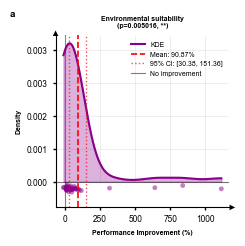

分布图已保存到: Supplymentary_figure/ccd_significance_emission.png


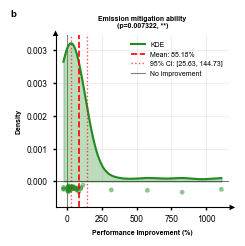

分布图已保存到: Supplymentary_figure/ccd_significance_economic.png


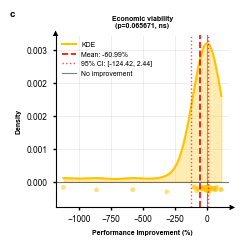

总体分布图已保存到: Supplymentary_figure/ccd_significance_overall.png


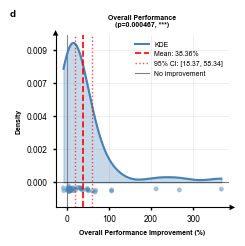

In [10]:
# 使用示例
if __name__ == "__main__":

    significance_results = calculate_ccd_significance_analysis(merged_df)